In [ ]:
pip install optuna

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Load Dataset Pima Diabetes

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import optuna

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

# URL dataset di GitHub (gunakan raw link)
url = "https://raw.githubusercontent.com/rilufiyy/GWO-with-Levy-Flight---Pima-Diabetes/main/diabetes.csv"

# Tampilkan
df = pd.read_csv(url)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
import numpy as np

# Ganti nilai 0 pada kolom Glucose, BloodPressure, SkinThickness, Insulin, BMI menjadi NaN
cols_with_invalid_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_invalid_zeros] = df[cols_with_invalid_zeros].replace(0, np.nan)

In [ ]:
# Cek Apakah ada missing value pada dataset
missing_value = df.isnull().sum()
print(missing_value)

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [ ]:
# Buat variabel dataframe yang dibersihkan
df_cleaned = df.copy()

# Imputasi nilai tidak valid (nan) sesuai distribusi data
df_cleaned['Glucose'].fillna(df_cleaned['Glucose'].mean(), inplace = True)
df_cleaned['BloodPressure'].fillna(df_cleaned['BloodPressure'].mean(), inplace = True)
df_cleaned['SkinThickness'].fillna(df_cleaned['SkinThickness'].median(), inplace = True)
df_cleaned['Insulin'].fillna(df_cleaned['Insulin'].median(), inplace = True)
df_cleaned['BMI'].fillna(df_cleaned['BMI'].median(), inplace = True)

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


# Splitting Data

In [ ]:
X = df_cleaned.drop('Outcome', axis=1)
y = df_cleaned['Outcome']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

In [ ]:
# Hitung jumlah data
total_data = df_cleaned.shape[0]
train_data = X_train.shape[0]
test_data = X_test.shape[0]

# Hitung persentase
train_pct = (train_data / total_data) * 100
test_pct = (test_data / total_data) * 100

# Tampilkan hasil
print(f'Jumlah data awal        : {total_data} baris')
print(f'Jumlah data latih       : {train_data} baris ({train_pct:.2f}%)')
print(f'Jumlah data uji         : {test_data} baris ({test_pct:.2f}%)')

Jumlah data awal        : 768 baris
Jumlah data latih       : 537 baris (69.92%)
Jumlah data uji         : 231 baris (30.08%)


# Data Scaling

In [ ]:
# Scaling data menggunakan MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Data Resampling

In [ ]:
# Cek jumlah outcome pada data latih
y_train.value_counts()

,count
Outcome,
0,349
1,188


Distribusi kelas sebelum resampling:
Outcome
0    349
1    188
Name: count, dtype: int64

Distribusi kelas setelah resampling:
Outcome
0    332
1    332
Name: count, dtype: int64


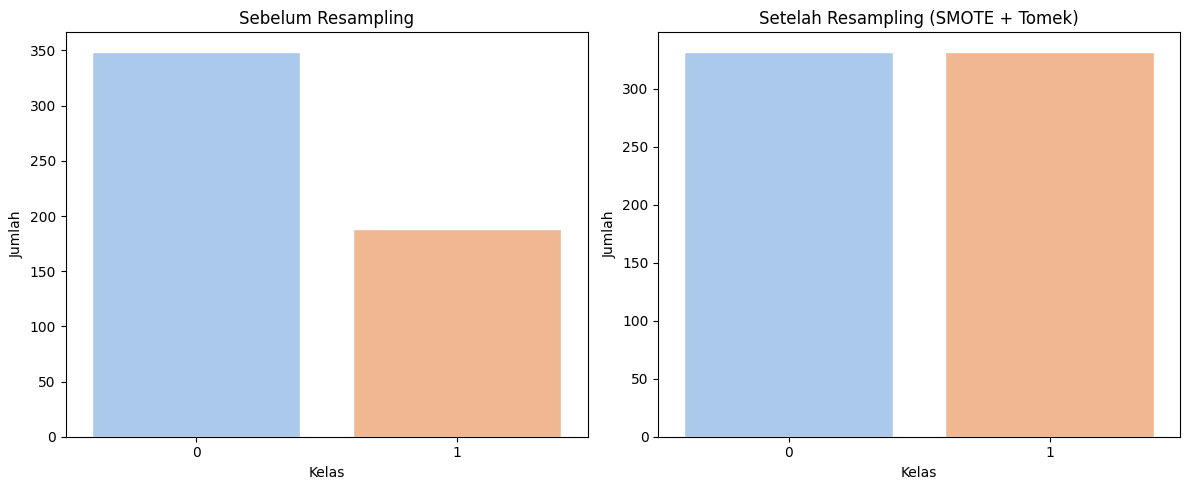

In [ ]:
from imblearn.combine import SMOTETomek
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tampilkan distribusi kelas sebelum resampling
print("Distribusi kelas sebelum resampling:")
print(pd.Series(y_train).value_counts())

# Lakukan resampling
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

# Tampilkan distribusi kelas setelah resampling
print("\nDistribusi kelas setelah resampling:")
print(pd.Series(y_train_resampled).value_counts())

# Visualisasi distribusi sebelum dan sesudah
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.set_style("whitegrid")

# Sebelum resampling
sns.countplot(x=y_train, ax=axes[0], palette="pastel")
axes[0].set_title("Sebelum Resampling")
axes[0].set_xlabel("Kelas")
axes[0].set_ylabel("Jumlah")

# Setelah resampling
sns.countplot(x=y_train_resampled, ax=axes[1], palette="pastel")
axes[1].set_title("Setelah Resampling (SMOTE + Tomek)")
axes[1].set_xlabel("Kelas")
axes[1].set_ylabel("Jumlah")

plt.tight_layout()
plt.show()

# Modeling

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import recall_score, make_scorer
import math
import random

# --- SETUP ---

# Mapping criterion
criterion_map = {0: 'gini', 1: 'entropy', 2: 'log_loss'}

# Bounds in form: [min, max] for each hyperparameter
bounds = np.array([
    [2, 15],     # max_depth
    [13, 30],    # min_samples_split
    [4, 20],     # min_samples_leaf
    [0, 2]       # criterion_idx (discrete)
])

In [ ]:
def clamp_solution(sol):
    """Batasi nilai solusi agar tetap dalam bounds & bulatkan untuk yang perlu."""
    clamped = np.clip(sol, bounds[:, 0], bounds[:, 1])
    clamped[0] = int(round(clamped[0]))  # max_depth
    clamped[1] = int(round(clamped[1]))  # min_samples_split
    clamped[2] = int(round(clamped[2]))  # min_samples_leaf
    clamped[3] = int(round(clamped[3]))  # criterion_idx
    return clamped

def evaluate_solution(sol, X, y):
    """Evaluasi performa solusi dengan cross-validated recall score."""
    max_depth = int(sol[0])
    min_samples_split = int(sol[1])
    min_samples_leaf = int(sol[2])
    criterion = criterion_map[int(sol[3])]

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        class_weight='balanced',
        random_state=42
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(recall_score), n_jobs=-1)

    return np.mean(scores)

In [ ]:
def levy_flight(beta=1.5):
    """Menghasilkan langkah Lévy Flight 1D dengan distribusi Mantegna."""
    sigma_u = (math.gamma(1 + beta) * math.sin(math.pi * beta / 2) /
               (math.gamma((1 + beta) / 2) * beta * 2**((beta - 1) / 2)))**(1 / beta)
    u = np.random.normal(0, sigma_u)
    v = np.random.normal(0, 1)
    step = u / abs(v) ** (1 / beta)
    return step

In [ ]:
def levy_optimizer(X, y, n_agents=10, max_iter=50, alpha=0.5):
    population = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_agents, bounds.shape[0]))
    fitness = [evaluate_solution(clamp_solution(agent), X, y) for agent in population]

    best_idx = np.argmax(fitness)
    best_pos = population[best_idx].copy()
    best_score = fitness[best_idx]

    score_history = [best_score]

    for it in range(max_iter):
        for i in range(n_agents):
            step = np.array([levy_flight(beta=1.5) for _ in range(bounds.shape[0])])
            new_pos = population[i] + alpha * step
            new_pos = clamp_solution(new_pos)
            new_score = evaluate_solution(new_pos, X, y)

            if new_score > fitness[i]:
                population[i] = new_pos
                fitness[i] = new_score

                if new_score > best_score:
                    best_score = new_score
                    best_pos = new_pos.copy()

        score_history.append(best_score)
        print(f"Iter {it+1}/{max_iter} | Best Recall: {best_score:.4f}")

    return best_pos, best_score, score_history

In [ ]:
best_pos_levy, best_score_levy, history_levy = levy_optimizer(X_train_resampled, y_train_resampled)

Iter 1/50 | Best Recall: 0.8917
Iter 2/50 | Best Recall: 0.8917
Iter 3/50 | Best Recall: 0.8917
Iter 4/50 | Best Recall: 0.8917
Iter 5/50 | Best Recall: 0.8917
Iter 6/50 | Best Recall: 0.8917
Iter 7/50 | Best Recall: 0.8917
Iter 8/50 | Best Recall: 0.8917
Iter 9/50 | Best Recall: 0.8917
Iter 10/50 | Best Recall: 0.9157
Iter 11/50 | Best Recall: 0.9157
Iter 12/50 | Best Recall: 0.9157
Iter 13/50 | Best Recall: 0.9157
Iter 14/50 | Best Recall: 0.9157
Iter 15/50 | Best Recall: 0.9157
Iter 16/50 | Best Recall: 0.9157
Iter 17/50 | Best Recall: 0.9157
Iter 18/50 | Best Recall: 0.9157
Iter 19/50 | Best Recall: 0.9157
Iter 20/50 | Best Recall: 0.9157
Iter 21/50 | Best Recall: 0.9157
Iter 22/50 | Best Recall: 0.9157
Iter 23/50 | Best Recall: 0.9157
Iter 24/50 | Best Recall: 0.9157
Iter 25/50 | Best Recall: 0.9157
Iter 26/50 | Best Recall: 0.9157
Iter 27/50 | Best Recall: 0.9157
Iter 28/50 | Best Recall: 0.9157
Iter 29/50 | Best Recall: 0.9157
Iter 30/50 | Best Recall: 0.9186
Iter 31/50 | Best R

In [ ]:
import optuna

# Konversi hasil Lévy ke range sempit
suggested_bounds = {
    "max_depth": (max(2, int(best_pos_levy[0]) - 2), min(15, int(best_pos_levy[0]) + 2)),
    "min_samples_split": (max(13, int(best_pos_levy[1]) - 2), min(30, int(best_pos_levy[1]) + 2)),
    "min_samples_leaf": (max(4, int(best_pos_levy[2]) - 2), min(20, int(best_pos_levy[2]) + 2)),
    "criterion": ["gini", "entropy", "log_loss"]
}

# Simpan history optuna untuk plot
history_optuna = []

def objective(trial):
    max_depth = trial.suggest_int("max_depth", *suggested_bounds["max_depth"])
    min_samples_split = trial.suggest_int("min_samples_split", *suggested_bounds["min_samples_split"])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", *suggested_bounds["min_samples_leaf"])
    criterion = trial.suggest_categorical("criterion", suggested_bounds["criterion"])

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        criterion=criterion,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced',
        random_state=42
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = np.mean(cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring=make_scorer(recall_score), n_jobs=-1))

    history_optuna.append(score)  # Track learning
    return score

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print(" Best trial found:")
print(f"  Mean Recall Score: {study.best_value:.4f}")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-07-23 05:14:43,783] A new study created in memory with name: no-name-839b3d67-389e-43f2-a925-72ee471bca2d
[I 2025-07-23 05:14:43,834] Trial 0 finished with value: 0.8765264586160109 and parameters: {'max_depth': 5, 'min_samples_split': 29, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 0 with value: 0.8765264586160109.
[I 2025-07-23 05:14:43,893] Trial 1 finished with value: 0.8764812302125735 and parameters: {'max_depth': 5, 'min_samples_split': 27, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 0 with value: 0.8765264586160109.
[I 2025-07-23 05:14:43,936] Trial 2 finished with value: 0.814111261872456 and parameters: {'max_depth': 2, 'min_samples_split': 28, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 0 with value: 0.8765264586160109.
[I 2025-07-23 05:14:43,984] Trial 3 finished with value: 0.8434644957033017 and parameters: {'max_depth': 5, 'min_samples_split': 29, 'min_samples_leaf': 17, 'criterion': 'entropy'}. Best is trial 0 with

 Best trial found:
  Mean Recall Score: 0.9186
  max_depth: 3
  min_samples_split: 27
  min_samples_leaf: 17
  criterion: gini


In [ ]:
# Buat model dari best_params dan latih di training set
best_model = DecisionTreeClassifier(
    **study.best_params,
    class_weight='balanced',
    random_state=42
)
best_model.fit(X_train, y_train)

# Prediksi & evaluasi
from sklearn.metrics import classification_report, confusion_matrix
y_pred = best_model.predict(X_test)

print("\n Classification Report (Test Set):")
print(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes']))


 Classification Report (Test Set):
              precision    recall  f1-score   support

 No Diabetes       0.87      0.56      0.68       151
    Diabetes       0.50      0.84      0.63        80

    accuracy                           0.66       231
   macro avg       0.69      0.70      0.66       231
weighted avg       0.74      0.66      0.66       231



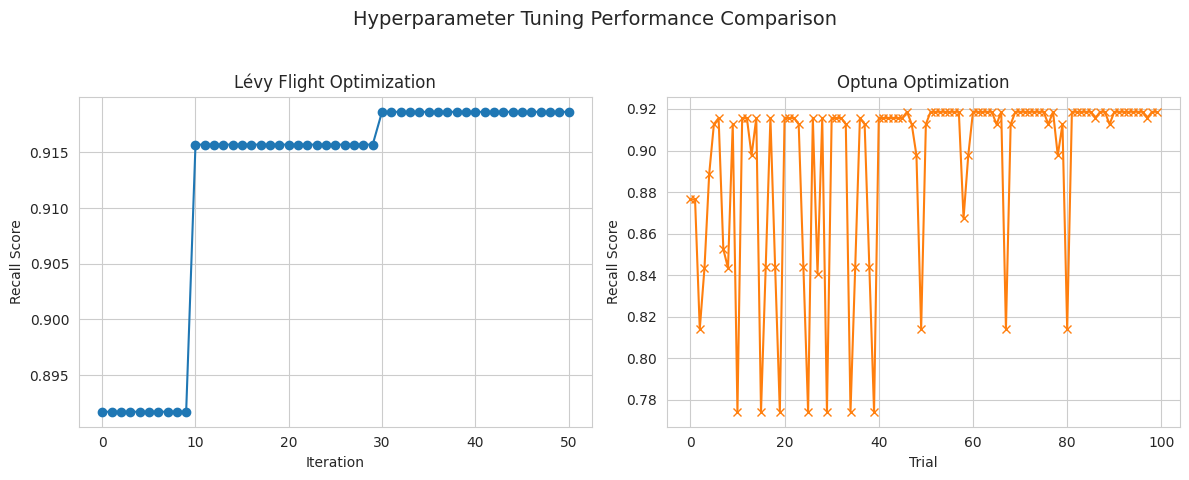

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Lévy Flight
plt.subplot(1, 2, 1)
plt.plot(history_levy, label="Lévy Flight", marker='o', color='tab:blue')
plt.xlabel("Iteration")
plt.ylabel("Recall Score")
plt.title("Lévy Flight Optimization")
plt.grid(True)
plt.tight_layout()

# Plot Optuna
plt.subplot(1, 2, 2)
plt.plot(history_optuna, label="Optuna", marker='x', color='tab:orange')
plt.xlabel("Trial")
plt.ylabel("Recall Score")
plt.title("Optuna Optimization")
plt.grid(True)
plt.tight_layout()

plt.suptitle("Hyperparameter Tuning Performance Comparison", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

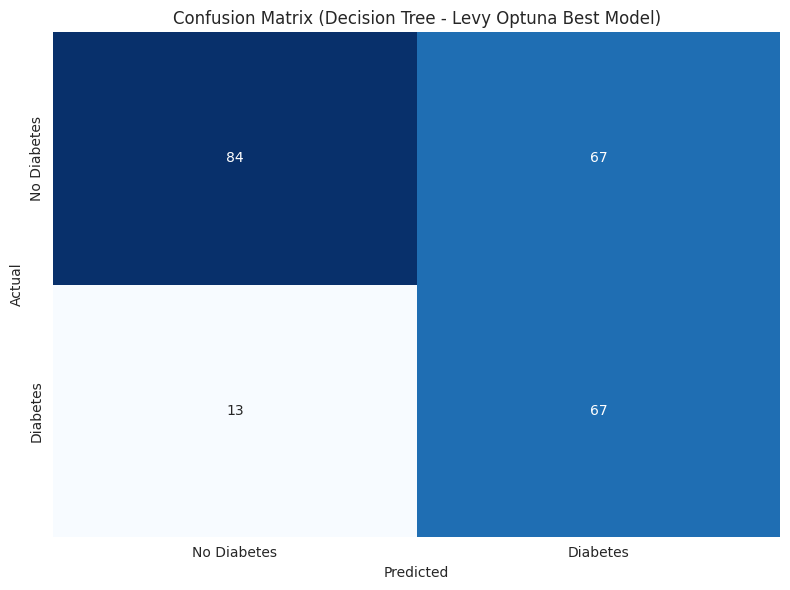

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ambil parameter terbaik dari Optuna
best_params = study.best_params

# Buat model dengan parameter hasil tuning
best_model = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    criterion=best_params['criterion'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    class_weight='balanced',
    random_state=42
)

# Fit model ke seluruh data training
best_model.fit(X_train_resampled, y_train_resampled)

# Prediksi data uji
y_pred = best_model.predict(X_test_scaled)

# Buat confusion matrix
cm_dt = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
                 xticklabels=['No Diabetes', 'Diabetes'],
                 yticklabels=['No Diabetes', 'Diabetes'],
                 cbar=False,
                 linewidths=0,
                 linecolor='white')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Decision Tree - Levy Optuna Best Model)')

# Hilangkan garis tepi
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()